## Benchmark: `to_tensor` versus `to_quimb_tensor`

We start by implementing a class `CircuitGenerator` that generates a ZX circuit in the form of a graph. There are two main methods that we use: the first is to simply call the method `CNOT_HAD_PHASE_circuit` from PyZX library, and the other generates multiple layers, each one consisting of CZ gates and two Z spiders on the first line with random phases. The latter has the effect of producing dense graphs.

In [1]:
import sys; sys.path.append('..')
import matplotlib.pyplot as plt
import quimb.tensor as qtn
import cotengra as ctg
import quimb as qu
import numpy as np
import pyzx as zx
import time, random

class CircuitGenerator:
    def __init__(self, dense: bool = False, qubits: int = 5, depth: int = 10):
        assert qubits > 0, "The number of qubits must be positive."
        assert depth > 0, "The depth must be positive."
        self.__dense = dense
        self.__qubits = qubits
        self.__depth = depth
    
    def __call__(self) -> zx.Graph:
        if self.__dense:
            return self.__dense_graph(qubits = self.__qubits, layers_count = self.__depth)
        else:
            return zx.generate.CNOT_HAD_PHASE_circuit(qubits = self.__qubits,
                                                      depth = self.__depth,
                                                      clifford = False).to_graph()
        
    def __dense_graph(self, qubits, layers_count: int = 10) -> zx.Graph:
        # The construction does not make sense for only one qubits.
        assert qubits > 1, "There should be at least two qubits."
        
        g = zx.Graph()
        inputs = [g.add_vertex(zx.VertexType.BOUNDARY, qubit = i, row = 0) for i in range(qubits)]
        outputs = [g.add_vertex(zx.VertexType.BOUNDARY, qubit = i, row = 4 * layers_count + 1) for i in range(qubits)]

        # This local function adds a new layer having a particular shape;
        # we need the previous `qubits` nodes along each line, together with the
        # index `cnt` of the layer we need to construct.
        # It returns the new last vertex on each line.
        def add_layer(prev, cnt):
            # Create the vertices.
            layer = [g.add_vertex(zx.VertexType.Z,
                            qubit = (i + 1) // 2,
                            row = 4 * cnt + (1 if i % 4 < 2 else 2)) for i in range(2 * qubits - 2)]
            # Construct the edges between these `2 * qubits - 2` vertices in a zig-zag shape.
            H, S = zx.EdgeType.HADAMARD, zx.EdgeType.SIMPLE
            for i in range(2 * qubits - 3):
                g.add_edge(g.edge(layer[i], layer[i + 1]), edgetype = H if i % 2 == 0 else S)

            # We collect the first (front) and the last (end) vertex on each of the `qubits` lines.
            front_indices, end_indices = [], []
            front_indices.append(0)
            end_indices.append(0)
            for i in range(1, qubits - 1):
                front_indices.append(2 * i - (i & 1))
                end_indices.append(2 * i - (i + 1 & 1))
            front_indices.append(2 * qubits - 3)
            end_indices.append(2 * qubits - 3)
            
            # Connect the previous layer (or the inputs if this is to be the first one)
            # to the current layer.
            for i in range(qubits):
                g.add_edge(g.edge(prev[i], layer[front_indices[i]]), zx.EdgeType.SIMPLE)

            # Add two randomised red vertices along each wire:
            # Their phases are k * pi / 4 and l * pi / 4, where k and l are independent
            # and uniformly distributed over {0, 1, ..., 7}.
            prev = []
            for i in range(qubits):   
                [k, l] = [g.add_vertex(zx.VertexType.X,
                                       phase = (random.randrange(8)) / 4.,
                                       qubit = i,
                                       row = 4 * cnt + j + 3) for j in range(2)]
                g.add_edge(g.edge(layer[end_indices[i]], k), edgetype = zx.EdgeType.SIMPLE)
                g.add_edge(g.edge(k, l), edgetype = zx.EdgeType.SIMPLE)
                prev.append(l)
            return prev

        # Add all layers whilst updating the prev vertices.
        prev = inputs
        for cnt in range(layers_count):
            prev = add_layer(prev, cnt)

        # Connect the prev vertices with the outputs.
        for i in range(qubits):
            g.add_edge(g.edge(prev[i], outputs[i]), zx.EdgeType.SIMPLE)

        # Set the inputs and outputs
        g.auto_detect_io()
        return g

Now we implement a class `CircuitBenchmark` which performs time profiling of `to_tensor` and `to_quimb_tensor`:
* The constructor sets up fields `n` for the number of circuits to be averaged in one go, `dense` flag which specifies whether dense graphs are to be used or not, and `full_reduce` which specifies whether the function with the same name from `PyZX` ought to be used before converting the diagrams to circuits.
* A private method `run_tensor` is used to generate a circuit, convert it to a graph, use kets 0 as inputs and bras 0 as outputs and calculate the required times for this diagram.
* Another private method `run_tensors` which simply calls `run_tensor` multiple (`n`) times and returns the average times.
* A public method `run_with_qubits` which takes the depth and a range to change the number of qubits in each iteration as inputs; returns two lists containing the times for obtaining the normal and quimb tensor networks, respectively.
* A public method `run_with_depths` which is the same as before but now the number of qubits is fixed and the depth varies.
* A public method `display_plot` which plots tensor and quimb times.
* A static method `get_tabel` which returns a string that tabulates tensor and quimb times.* A public method `display_tabel_and_plot` which both tabulates and plots the same data.

In [2]:
class CircuitBenchmark():
    def __init__(self, n: int, dense: bool = False, full_reduce: bool = False):
        self.__n = n
        self.__dense = dense
        self.__full_reduce = full_reduce
    
    def run_with_qubits(self, depth, qubits_range):
        tensor_times, quimb_times = [], []
        self.__depth = depth
        for qubits in qubits_range:
            self.__qubits = qubits
            self.__generator = CircuitGenerator(self.__dense, qubits, depth)
            tensor_time, quimb_time = self.__run_tensors()
            tensor_times.append(tensor_time)
            quimb_times.append(quimb_time)
        return tensor_times, quimb_times

    def run_with_depths(self, qubits, depth_range):
        tensor_times, quimb_times = [], []
        self.__qubits = qubits
        for depth in depth_range:
            self.__depth = depth
            self.__generator = CircuitGenerator(self.__dense, qubits, depth)
            tensor_time, quimb_time = self.__run_tensors()
            tensor_times.append(tensor_time)
            quimb_times.append(quimb_time)
        return tensor_times, quimb_times
    
    def __run_tensor(self):
        # Generate a circuit and convert it to a graph object
        g = self.__generator()
        g.apply_state("0" * self.__qubits)  # use kets 0 as inputs
        g.apply_effect("0" * self.__qubits) # use bras 0 as outputs
        zx.to_gh(g)                         # get rid of red spiders
        if self.__full_reduce:
            zx.full_reduce(g)

        # Profiling to_tensor
        t = time.time()
        tensor = g.to_tensor()
        tensor_time = time.time() - t
        
        # Profiling to_quimb_tensor
        t = time.time()
        quimb_tn = zx.to_quimb_tensor(g).contract(output_inds = ())
        quimb_time = time.time() - t
        
        # Assert correctness and update the list fields.
        assert abs(quimb_tn - tensor) < 1e-9, "to_tensor and to_quimb_tensor don't exhibit the same result"
        self.__tensor_times.append(tensor_time)
        self.__quimb_times.append(quimb_time)
    
    def __run_tensors(self):
        self.__tensor_times = []
        self.__quimb_times = []
        for _ in range(self.__n):
            self.__run_tensor()
        return (np.mean(self.__tensor_times), np.mean(self.__quimb_times))
    
    def display_plot(self, tensor_times, quimb_times, range, has_qubits: bool):
        var_type, fixed_type, fixed_quant = ("qubits", "depth", self.__depth) if has_qubits else \
                                          ("depth", "qubits", self.__qubits)
        fig, ax = plt.subplots()
        ax.plot(range, tensor_times, label = "to_tensor")
        ax.plot(range, quimb_times, label = "to_quimb_tensor")
        ax.set_xlabel(var_type)
        ax.set_ylabel("time (s)")
        ax.set_title(
            "From {} to {} {}, fixed {} of {}".format(
                range[0], range[-1], var_type, fixed_type, fixed_quant
            )
        )
        ax.legend()
    
    @staticmethod
    def get_table(var, range_var, tensor_times, quimb_times):
        def list_to_row(name, elems):
            s = name.ljust(15)
            is_first = True
            for x in elems:
                if is_first:
                    is_first = False
                else:
                    s += " | "
                s += str(x).rjust(7) if isinstance(x, int) else "{:.3f}".format(x).rjust(7)
            s += '\n'
            return s
        
        s = list_to_row(f"{var}:", range_var)
        s += list_to_row("Tensor times:", tensor_times)
        s += list_to_row("Quimb times:", quimb_times)
        return s
    
    def display_tabel_and_plot(self, tensor_times, quimb_times, range, has_qubits: bool):
        var_type, fixed_type, fixed_quant = ("Qubits", "depth", self.__depth) if has_qubits else \
                                            ("Depth", "qubits", self.__qubits)
        str_full_reduce = " (with full_reduce = True)" if self.__full_reduce else ""
        print("For {} {}{}:\n".format(fixed_quant, fixed_type, str_full_reduce))
        print(CircuitBenchmark.get_table(var_type, range, tensor_times, quimb_times))
        self.display_plot(tensor_times, quimb_times, range, has_qubits)
    
    def test(self, has_qubits: bool, fixed_quant: int, range, with_table: bool = False):
        tensor_times, quimb_times = self.run_with_qubits(fixed_quant, range) if has_qubits \
            else self.run_with_depths(fixed_quant, range)
        if with_table:
            self.display_tabel_and_plot(tensor_times, quimb_times, range, has_qubits)
        else:
            self.display_plot(tensor_times, quimb_times, range, has_qubits)

We now compare `to_tensor` against `to_quimb_tensor` by fixing the depth and varying the number of qubits, while `dense` and `full_reduce` are, by default, `False`:

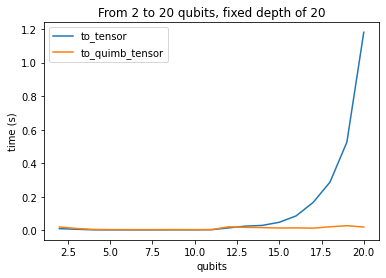

In [3]:
cb = CircuitBenchmark(3)
cb.test(has_qubits = True, fixed_quant = 20, range = range(2, 21))

The time for transforming the circuit into a normal tensor network and contracting it takes time that increases exponentially with the number of qubits when the depth is fixed, whereas the time for building and contracting the corresponding Quimb tensor network remains (roughly) constant.

Now we fix the number of qubits and change the depth:

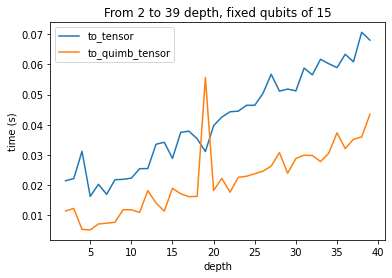

In [4]:
cb.test(has_qubits = False, fixed_quant = 15, range = range(2, 40))

Interestingly, as the depth increases and the number of qubits is fixed, both tasks seem to perform the same up to a constant factor; the curves are roughly linear. Quimb definitely has the better constant.

Now we repeat the same experiments but with `full_reduce = True`. We will increase the size of the circuits, otherwise `full_reduce` reduces the graph to a simple scalar and the results are worthless.

For 150 depth (with full_reduce = True):

Qubits:              3 |       4 |       5 |       6 |       7 |       8 |       9 |      10
Tensor times:    0.002 |   0.011 |   0.011 |   0.050 |   1.140 |   0.169 |   0.001 |   0.002
Quimb times:     0.006 |   0.020 |   0.020 |   0.019 |   0.015 |   0.013 |   0.001 |   0.007



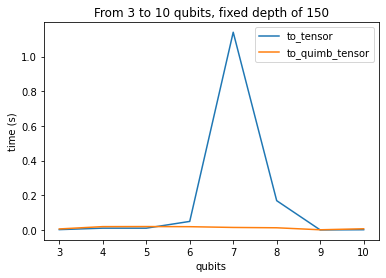

In [6]:
cb = CircuitBenchmark(5, full_reduce = True)
cb.test(has_qubits = True, fixed_quant = 150, range = range(3, 11), with_table = True)

When the depth is fixed, there are certain situations when the normal method is better, but overall Quimb is better because, as the the number of qubits gets higher, some circuits take exponentially more time to be contracted with `to_tensor`, which leads to spikes in the graph. This is mostly likely due to the fact that `full_reduce` can introduce spiders with many wires, which in turn results in an exponential time increase with `to_tensor`.

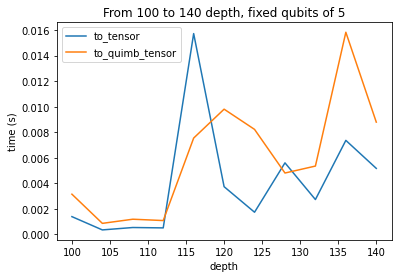

In [12]:
cb.test(has_qubits = False, fixed_quant = 5, range = range(100, 141, 4))

As with `full_reduce = False`, we got two functions that grow almost the same at the beginning, up to a constant factor. `to_tensor` usually performs slightly better, but as before there are occasional spikes which occur because of spiders with many wires, whereas `to_quimb_tensor` doesn't have this problem.

Now we do some experiments with dense graphs:

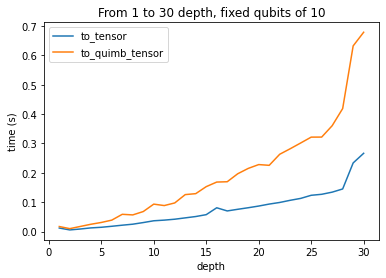

In [13]:
cb = CircuitBenchmark(5, dense = True)
cb.test(has_qubits = False, fixed_quant = 10, range = range(1, 31))

When the number of qubits is fixed, both curves increase linearly but, perhaps surprisingly, `to_tensor` has the better constant. This might be due to the fact that `to_tensor` has a deterministic, numerical path that it always chooses and is near optimal, whereas Quimb has to find the path before the contraction itself.

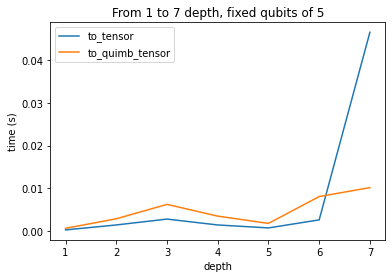

In [16]:
cb = CircuitBenchmark(n = 5, dense = True, full_reduce = True)
cb.test(has_qubits = False, fixed_quant = 5, range = range(1, 8))

When `full_reduce` comes into play, there are two possible scenarios: either the graph is simplied enough so that we end up with a small graph and `to_tensor` slightly outperforms `to_quimb_tensor` because the former employs a numerical order path whereas the latter needs to find a path before doing the contraction, or the simplification leads to a complex graph where there are spiders with many wires and that leads to an explosion (spike) in time for `to_tensor` which is not the case for `to_quimb_tensor`.

### Comparing different contraction path finder strategies
Now we will look at different contraction strategies that Quimb can use when performing the contraction. It is very important to note that finding the contraction path and actually performing the contraction are done separately and there is a performance trade off between them.

We employ some Cotengra optimizers, namely **Greedy** (an agglomerative approach), **KaHyPar** (a divisive approach, i.e. building the contraction tree from the top down), **Labels** (a community detection algorithm, using the usual betweenness measure but for hypergraphs) and **Optimal** (an approach that finds the optimal contraction path using dynamic programming) as per [this](https://quantum-journal.org/papers/q-2021-03-15-410/) paper.

The class `QuimbStrategies` that we use for this benchmark is very similar to the one above, having methods with the same labels.

In [3]:
class QuimbStrategies:
    def __init__(self, n: int, strategies, dense: bool = False, full_reduce: bool = False):
        self.__n = n
        self.__strategies = strategies
        self.__dense = dense
        self.__full_reduce = full_reduce
    
    def run_with_qubits(self, depth, qubits_range):
        times = [[] for _ in range(1 + len(self.__strategies))]
        self.__depth = depth
        
        for qubits in qubits_range:
            self.__qubits = qubits
            self.__generator = CircuitGenerator(self.__dense, qubits, depth)
            methods_times = self.__run_tensors()
            for i, time in enumerate(methods_times):
                times[i].append(time)
        return times
    
    def run_with_depths(self, qubits, depth_range):
        times = [[] for _ in range(1 + len(self.__strategies))]
        self.__qubits = qubits
        
        for depth in depth_range:
            self.__depth = depth
            self.__generator = CircuitGenerator(self.__dense, qubits, depth)
            methods_times = self.__run_tensors()
            for i, time in enumerate(methods_times):
                times[i].append(time)
        return times
    
    def __run_tensor(self):
        g = self.__generator()
        g.apply_state("0" * self.__qubits)
        g.apply_effect("0" * self.__qubits)
        zx.to_gh(g)
        if self.__full_reduce:
            zx.full_reduce(g)
        
        t = time.time()
        tensor = zx.to_quimb_tensor(g).contract(output_inds = ())
        self.__times[0].append(time.time() - t)
        
        for i, method in enumerate(self.__strategies):
            t = time.time()
            tn = zx.to_quimb_tensor(g)
            tn.full_simplify_("ADCRS", output_inds = [], equalize_norms = True)
            opt = ctg.HyperOptimizer(max_repeats = 1, methods = [method], minimize = "combo")
            tn.contract(optimize = opt, output_inds = [])
            self.__times[i + 1].append(time.time() - t)
    
    def __run_tensors(self):
        self.__times = [[] for _ in range(1 + len(self.__strategies))]
        for _ in range(self.__n):
            self.__run_tensor()
        return [np.mean(collection_of_times) for collection_of_times in self.__times]
    
    def display_plot(self, times, range, has_qubits: bool):
        var_type, fixed_type, fixed_quant = ("qubits", "depth", self.__depth) if has_qubits else \
                                            ("depth", "qubits", self.__qubits)
        fig, ax = plt.subplots()
        for i, method_times in enumerate(times):
            ax.plot(range, method_times, '--', label = "basic" if i == 0 else self.__strategies[i - 1])
        ax.set_xlabel(var_type)
        ax.set_ylabel("time (s)")
        ax.set_title(
            "From {} to {} {}, fixed {} of {}".format(
                range[0], range[-1], var_type, fixed_type, fixed_quant
            )
        )
        ax.legend()
    
    def test(self, has_qubits: bool, fixed_quant: int, range):
        times = self.run_with_qubits(fixed_quant, range) if has_qubits \
                    else self.run_with_depths(fixed_quant, range)
        qs.display_plot(times, range, has_qubits)

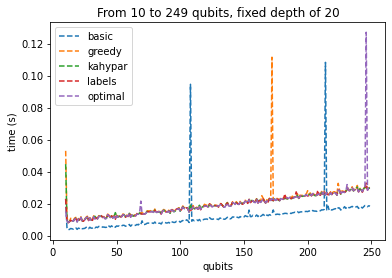

In [11]:
qs = QuimbStrategies(1, ["greedy", "kahypar", "labels", "optimal"])
qs.test(has_qubits = True, fixed_quant = 20, range = range(10, 250))

We deduce that the Cotengra optimizers perform well and almost the same when the number of qubits varies, <span style="color: red">but are worse than the basic one because of the time needed to find the path.</span> **We emphasize here that the basic optimizer is implemented as part of Quimb, whereas the other ones are part of the Cotengra library, so their integration with Quimb might have a significant overhead.**

In [12]:
qs = QuimbStrategies(3, ["greedy", "kahypar", "labels", "optimal"])
qs.test(has_qubits = False, fixed_quant = 50, range = range(50, 61))

/home/paul/.local/lib/python3.8/site-packages/quimb/tensor/tensor_core.py:7161: RuntimeWarning: invalid value encountered in true_divide
  t.modify(apply=lambda data: data / stripped_factor)
/home/paul/.local/lib/python3.8/site-packages/autoray/autoray.py:84: RuntimeWarning: divide by zero encountered in log10
  return get_lib_fn(backend, fn)(*args, **kwargs)


KeyboardInterrupt: 

When the depth varies and the number of qubits is fixed, the same behaviour can be observed as when comparing `to_tensor` against `to_quimb_tensor`. The graphs increase linearly; the slope for the custom methods are (almost) identical and worse than the one for the basic optimizer. Ocasional spikes occur for all methods.

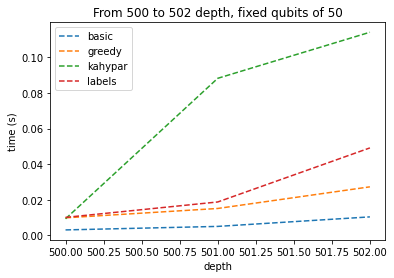

In [6]:
qs = QuimbStrategies(1, ["greedy", "kahypar", "labels"], full_reduce = True)
qs.test(has_qubits = False, fixed_quant = 50, range = range(500, 503))

In [ ]:
qs = QuimbStrategies(5, ["greedy", "kahypar", "labels"], dense = True)
qs.test(has_qubits = False, fixed_quant = 30, range = range(10, 21))

When switching to dense circuits, we can observe that **KaHyPar** performs worse than all the others; the **Greedy** optimizer performs very close to the basic one, suggesting that the difference is due to the latter being native to Quimb. **Betweenness**'s performance is very good but still worse than the greedy approach.

In [13]:
qs = QuimbStrategies(2, ["greedy", "kahypar", "labels"], dense = True, full_reduce = True)
qs.test(has_qubits = False, fixed_quant = 5, range = range(2, 16))

BrokenProcessPool: A child process terminated abruptly, the process pool is not usable anymore

In [7]:
gen = CircuitGenerator(qubits = 4, dense  =True, depth = 3)
g = gen()
zx.draw(g)

When performing `full_reduce` before transforming the diagram into a tensor network, the same behaviour can be observed, even more extreme because of the spikes that appear for Cotengra optimizers.